Using Claire's eulerian streamfunction to calculate AMOC strength (https://github.com/claireyung/unsw_clex_project_files/blob/help/Eulerian_Overturning.ipynb).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
from dask.distributed import Client
import xarray as xr
import xgcm
from xgcm import Grid

In [2]:
client = Client(n_workers=8)
client

distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/36805358.gadi-pbs/dask-worker-space/worker-ts6luqsf', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 80.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44421,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 80.00 GiB
Comm: tcp://127.0.0.1:33293,Total threads: 1
Dashboard: /proxy/35915/status,Memory: 10.00 GiB
Nanny: tcp://127.0.0.1:40319,


In [3]:
expt_cont = '1deg_jra55_ryf_RCPcont'
expt_cool = '1deg_jra55_ryf_RCPcoolhumid'
expt_warm = '1deg_jra55_ryf_RCPwarmhumid'

session = cc.database.create_session('/scratch/e14/cy8964/access-om2/archive/databases/1deg_jra55_ryf_experiments_2022.db')

In [47]:
v_cont = cc.querying.getvar(expt_cont,'v',session, ncfile = 'ocean.nc').chunk({'st_ocean':50})
v_cool = cc.querying.getvar(expt_cool,'v',session, ncfile = 'ocean.nc').chunk({'st_ocean':50})
v_warm = xr.open_mfdataset(paths=f'/scratch/e14/cy8964/access-om2/archive/{expt_warm}/output*/ocean/ocean.nc', \
                            combine='by_coords').v.chunk({'st_ocean':50})
# There was weirdness going on with xarray serialization warnings only for the warming experiment for some reason...! I didn't understand the error messages

dzt_cont = cc.querying.getvar(expt_cont,'dzt',session, ncfile = 'ocean.nc').chunk({'st_ocean':50})
dzt_cool = cc.querying.getvar(expt_cool,'dzt',session, ncfile = 'ocean.nc').chunk({'st_ocean':50})
dzt_warm = xr.open_mfdataset(paths=f'/scratch/e14/cy8964/access-om2/archive/{expt_warm}/output*/ocean/ocean.nc', \
                            combine='by_coords').dzt.chunk({'st_ocean':50})

dxt = cc.querying.getvar(expt_cont,'dxt',session, ncfile = 'ocean_grid.nc', n=1)
st_edges_ocean = cc.querying.getvar(expt_cont,'st_edges_ocean',session, ncfile = 'ocean.nc', n=1)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datet

In [50]:
st_edges = xr.DataArray(st_edges_ocean.values, coords = [st_edges_ocean.values], dims = ['st_edges_ocean'], name = 'st_edges')

In [51]:
# make dataset
ds = xr.merge([v_cont,dzt_cont,dxt,st_edges])

Interpolate v (xu_ocean) to (xt_ocean), and dzt and dxt (yt_ocean) to (yu_ocean) so that ends up on (xt_ocean, yu_ocean) grid

In [52]:
# Generate xgcm grid object:
grid = Grid(ds,coords={"x":{"center":"xt_ocean","right":"xu_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)

In [53]:
v_cont = grid.interp(v_cont, 'x',boundary = 'extend')
v_cool = grid.interp(v_cool, 'x',boundary = 'extend')
v_warm = grid.interp(v_warm, 'x',boundary = 'extend')

dzt_cont = grid.interp(dzt_cont, 'y',boundary = 'extend')
dzt_cool = grid.interp(dzt_cool, 'y',boundary = 'extend')
dzt_warm = grid.interp(dzt_warm, 'y',boundary = 'extend')

dxt = grid.interp(dxt, 'y',boundary = 'extend')

In [54]:
ty_trans_cont = v_cont*dzt_cont*dxt
ty_trans_cool = v_cool*dzt_cool*dxt
ty_trans_warm = v_warm*dzt_warm*dxt

In [55]:
# # Integrate transport from the bottom of the ocean
# Psi_Eulerian_cont = ty_trans_cont.sum('xt_ocean').sum('st_ocean') - grid.cumsum(ty_trans_cont.sum('xt_ocean'),'z',boundary="fill",fill_value=0)
# Psi_Eulerian_cool = ty_trans_cool.sum('xt_ocean').sum('st_ocean') - grid.cumsum(ty_trans_cool.sum('xt_ocean'),'z',boundary="fill",fill_value=0)
# Psi_Eulerian_warm = ty_trans_warm.sum('xt_ocean').sum('st_ocean')-grid.cumsum(ty_trans_warm.sum('xt_ocean'),'z',boundary="fill",fill_value=0)

In my density-latitude script to calculate AMOC strength (https://github.com/mpudig/HonoursThesis/blob/main/Figure_code/Fig7.ipynb), I did cumsum minus sum... With the above sign (order) for the calculation and taking the max at 26N then gives a min at 26N, so I do the following calculation with cumsum first.

In [56]:
# Integrate transport from the bottom of the ocean
Psi_Eulerian_cont = grid.cumsum(ty_trans_cont.sum('xt_ocean'),'z',boundary="fill",fill_value=0) - ty_trans_cont.sum('xt_ocean').sum('st_ocean')
Psi_Eulerian_cool = grid.cumsum(ty_trans_cool.sum('xt_ocean'),'z',boundary="fill",fill_value=0) - ty_trans_cool.sum('xt_ocean').sum('st_ocean')
Psi_Eulerian_warm = grid.cumsum(ty_trans_warm.sum('xt_ocean'),'z',boundary="fill",fill_value=0) - ty_trans_warm.sum('xt_ocean').sum('st_ocean')

In [58]:
AMOC_cont = Psi_Eulerian_cont.sel(method = 'Nearest', yu_ocean = 26).max('st_edges_ocean').sel(time=slice(None,'2999-12-31')).load() / 1e6
AMOC_cool = Psi_Eulerian_cool.sel(method = 'Nearest', yu_ocean = 26).max('st_edges_ocean').sel(time=slice(None,'2999-12-31')).load() / 1e6
AMOC_warm = Psi_Eulerian_warm.sel(method = 'Nearest', yu_ocean = 26).max('st_edges_ocean').sel(time=slice(None,'2999-12-31')).load() / 1e6

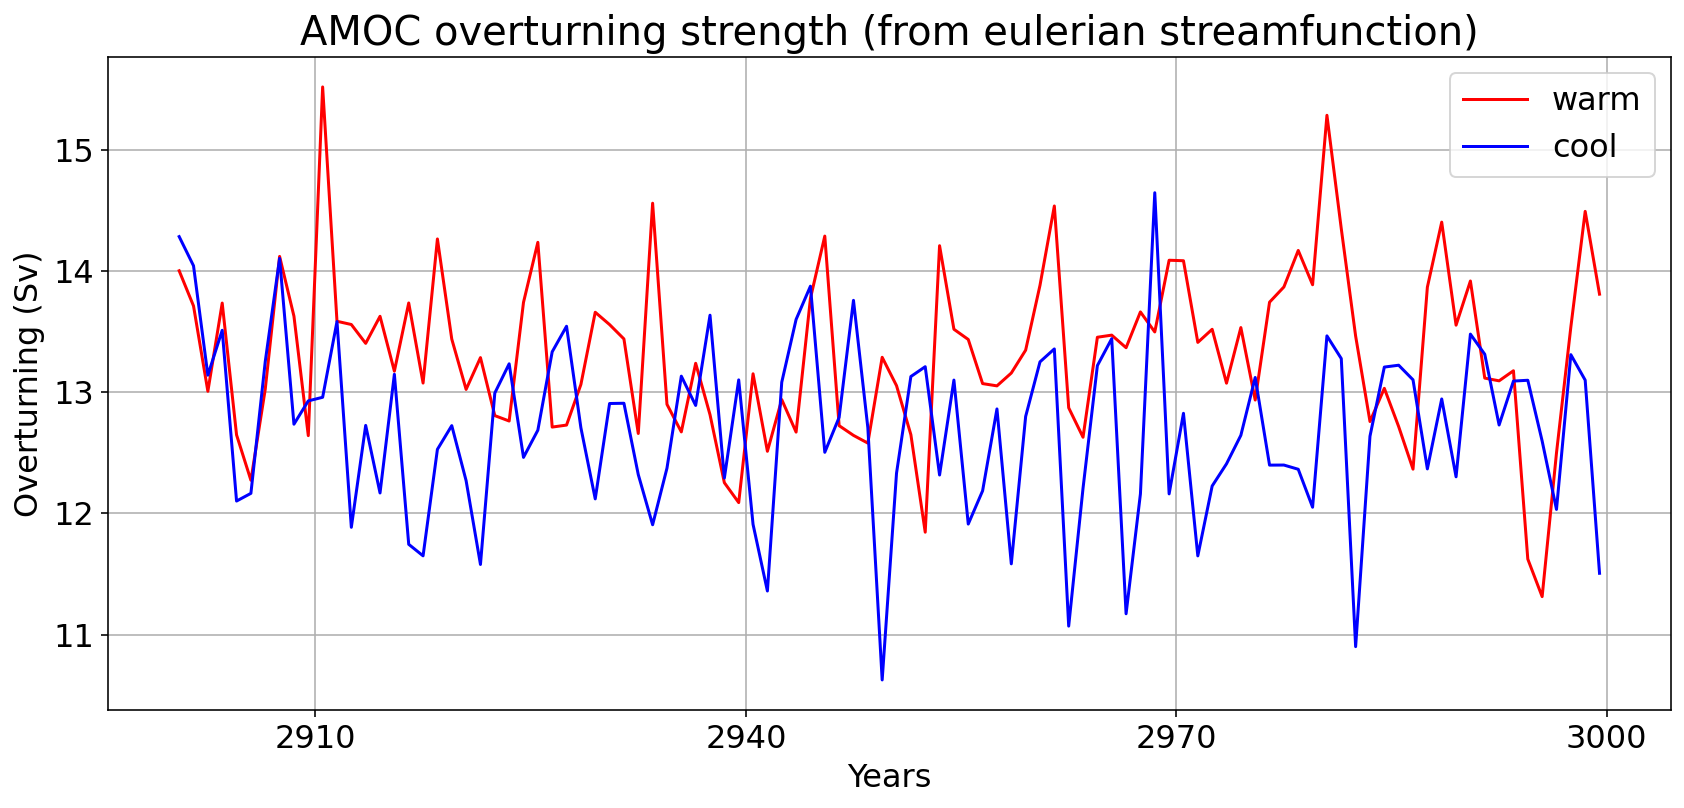

In [59]:
plt.figure(figsize=(14, 6))

AMOC_warm.plot(color='r',label='warm')
# AMOC_cont.plot(color='k',label='control', alpha=0.6)
AMOC_cool.plot(color='b',label='cool')

fontsize = 16
xlims = plt.xlim()
plt.xlabel('Years', fontsize=fontsize)
plt.ylabel('Overturning (Sv)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.title('AMOC overturning strength (from eulerian streamfunction)', fontsize=fontsize+4)
plt.grid()
# plt.savefig('AMOC_depth_lat